# Water Resources

**Metadata and Data Considerations**

Data is from the National Water and Climate Center (NWCC)

Data is csv format by state. For `AZ`, `CA`, CO, NM, NV, UT, WY
Data needs to be cleaned such that it only includes data for the Colorado River Basin.
Data contains many metrics. PCA may be necessary to reduce dimensionality of the dataset.

Default format = Date | Station | Metric 1 | Metric 2 | ... | Metric n 

Data split into multiple files per state as a result of the data acquisition process. Master dataset should include all data for the Colorado River Basin.<br>
File schema as follows:

Snow_\*.csv
- Station Name
- Station ID
- Snow Water Equivalent
- Snow Depth
- Snow Density
- Precipitation Acumulation
- Snow Rain Ratio
- Air Temperature Average
- Wind Speed Average
- Elevation
- Latitude
- Longitude

Soil_\*.csv
- Station Name
- Station ID
- Soil Temperature Average

Data may differ significantly over the period of record because of the effects of climate change in the region. We will attempt to use all period of record, but failing that, we will truncate the data. Data earlier than 2010 is likely not needed for predictions in following years and is likely too enstranged from current weather regimes to be useful and may instead present more error.

Target parameter is `suf_water`, which is an engineered binary parameter that will use predicted Snow Water Equivalent (SWE), the amount of water available to the water system from snow melt, and subtract it from water usage. A `0` represents a negative resulting number (not enough water), and a `1` represents a positive resulting number (enough water). 

According to research, targeting SWE directly is more effective than targeting snow depth. We will attempt to include meteorological data as well as soil temperature measurements and elevation.

Because we are comparing with water usage and water stores, reservoir data is required to compare snowpack data to determine whether water is sufficient. Water data is taken from NWCC's RESERVOIR dataset that includes reservoir stages and storage volumes. 

Water_\*.csv
- Station Name
- Station ID
- Reservoir Storage Volume (dam^3) Start of Day Values
- Elevation
- Latitude
- Longitude

#### Notes and Caveates

Snow and water data was clipped geographically using a Colorado River Basin shapefile and ESRI ArcGIS Pro on WGS 1984 Mercator Auxiliary Sphere projection. 

CA Water and Snow data lies outside the basin boundary and will be excluded from the analysis. We will do some more research into the water resource draw CA puts on the basin system to include at the end.

Some NV snow data lies within the basin boundary. NV Water reservoirs lie outside the basin boundary. Water resource draw by NV will have to be assessed similarly to CA.

### File Organizations



### Business Problem

Colorado River Board wants to be able to predict whether or not there will be sufficient water for the year or not to determine and recommend water use regulations in Colorado River.

## System setup and Information

Here we mount a google drive and check the system's physical attributes.

In [3]:
# Import general libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.pipeline import Pipeline

## Import Data from File, Explore and Format

Here we will Import and Format the data from file and perform some cursory analysis of the original data.

In [4]:
# Importing snow files into dataframes
snow_states = ['AZ', 'CO', 'NM', 'NV', 'UT', 'WY']
raw_snow = {}

for i in snow_states:
    raw_snow[i] = pd.read_csv(f'../00_Source_Data/Snowpack/{i}/Snow_{i}_Clip.csv')


# Importing water storage files into dataframes
water_states = ['AZ', 'CO', 'NM', 'UT', 'WY']
raw_water = {}

for i in water_states:
    raw_water[i] = pd.read_csv(f'../00_Source_Data/Snowpack/{i}/Water_{i}_Clip.csv')

In [5]:
raw_snow['AZ'].head()

,Date,Station Name,Station Id,Snow Water Equivalent (mm) Start of Day Values,Snow Depth (cm) Start of Day Values,Snow Density (pct) Start of Day Values,Precipitation Accumulation (mm) Start of Day Values,Snow Rain Ratio (unitless),Air Temperature Average (degC),Wind Speed Average (km/hr),Elevation (ft),Latitude,Longitude
0,1978-09-30,Baker Butte,308,NaN,NaN,NaN,NaN,NaN,0.0,NaN,7300,34.4566,-111.40643
1,1978-10-01,Baker Butte,308,NaN,NaN,NaN,NaN,NaN,0.0,NaN,7300,34.4566,-111.40643
2,1978-10-02,Baker Butte,308,NaN,NaN,NaN,NaN,NaN,0.0,NaN,7300,34.4566,-111.40643
3,1978-10-03,Baker Butte,308,NaN,NaN,NaN,NaN,NaN,0.0,NaN,7300,34.4566,-111.40643
4,1978-10-04,Baker Butte,308,NaN,NaN,NaN,NaN,NaN,0.0,NaN,7300,34.4566,-111.40643


In [6]:
# Standardizing column names for snow data.
column_names = {'Station_Name' : 'Station Name',
               'Station_Id' : 'Station ID',
               'Snow_Water_Equivalent__mm__Start_of_Day_Values' : 'SWE',
               'Snow_Depth__cm__Start_of_Day_Values' : 'Snow Depth',
               'Elevation__ft_' : 'Elevation',
               'Station Id' : 'Station ID',
               'Snow Water Equivalent (mm) Start of Day Values' : 'SWE',
               'Snow Depth (cm) Start of Day Values' : 'Snow Depth',
               'Snow Density (pct) Start of Day Values' : 'Snow Density',
               'Precipitation Accumulation (mm) Start of Day Values' : 'Precip Accumulation',
               'Snow Rain Ratio (unitless)' : 'Snow / Rain',
               'Air Temperature Average (degC)' : 'Average Air Temperature',
               'Wind Speed Average (km/hr)' : 'Average Wind Speed',
               'Elevation (ft)' : 'Elevation'}

for i in snow_states:
    raw_snow[i] = raw_snow[i].rename(columns=column_names)
    
# Standardizing column names for water storage data.
wa_column_names = {'Station_Name' : 'Station Name',
                   'Station_Id' : 'Station ID',
                   'Station Id' : 'Station ID',
                   'Reservoir Storage Volume (dam^3) Start of Day Values' : 'Water Storage',
                   'Reservoir_Storage_Volume__dam_3__Start_of_Day_Values' : 'Water Storage',
                   'Elevation (ft)' : 'Elevation',
                   'Elevation__ft_' : 'Elevation'}

for i in water_states:
    raw_water[i] = raw_water[i].rename(columns=wa_column_names)

In [7]:
# Combine the dataframes into one dataframe for snow data.
snow_data = pd.concat(raw_snow, axis=0)
water_data = pd.concat(raw_water, axis=0)

In [8]:
water_data

Date           Station Name  Station ID  Water Storage  \
AZ 0      1964-12-21   Cragin Dam Reservoir   9398300.0            0.0   
   1      1964-12-22   Cragin Dam Reservoir   9398300.0            NaN   
   2      1964-12-23   Cragin Dam Reservoir   9398300.0            NaN   
   3      1964-12-24   Cragin Dam Reservoir   9398300.0            NaN   
   4      1964-12-25   Cragin Dam Reservoir   9398300.0            NaN   
...              ...                    ...         ...            ...   
WY 59795  2022-03-29  Meeks Cabin Reservoir   9218400.0        15393.0   
   59796  2022-03-30  Meeks Cabin Reservoir   9218400.0        15470.0   
   59797  2022-03-31  Meeks Cabin Reservoir   9218400.0        15556.0   
   59798  2022-04-01  Meeks Cabin Reservoir   9218400.0        15642.0   
   59799  2022-04-02  Meeks Cabin Reservoir   9218400.0        15706.0   

          Elevation  Latitude  Longitude  OID_  
AZ 0         6620.0  34.55528 -111.18333   NaN  
   1         6620.0  34.55528 -111.18333   NaN  
   2         6620.0  34.55528 -111.18333   NaN  
   3         6620.0  34.55528 -111.18333   NaN  
   4         6620.0  34.55528 -111.18333   NaN  
...             ...       ...        ...   ...  
WY 59795     8673.0  41.02583 -110.58067   NaN  
   59796     8673.0  41.02583 -110.58067   NaN  
   59797     8673.0  41.02583 -110.58067   NaN  
   59798     8673.0  41.02583 -110.58067   NaN  
   59799     8673.0  41.02583 -110.58067   NaN  

[1010474 rows x 8 columns]

In [9]:
# Column Selection for master snow dataset
junk_columns = ['Station ID', 'Snow Density', 'Precip Accumulation', 'Snow / Rain', 'Average Air Temperature', 
                'Average Wind Speed', 'Elevation', 'Latitude', 'Longitude', 'OID_']

snow_data.drop(columns=junk_columns, inplace=True)

# Column Selection for master water storage dataset
water_data.drop(columns=['Station ID', 'Elevation', 'Latitude', 'Longitude', 'OID_'], inplace=True)

In [10]:
# Date time formatting
snow_data.index = pd.to_datetime(snow_data['Date'], infer_datetime_format=True)
snow_data.drop(columns='Date', inplace=True)

water_data.index = pd.to_datetime(water_data['Date'], infer_datetime_format=True)
water_data.drop(columns='Date', inplace=True)

In [11]:
snow_data

,Station Name,SWE,Snow Depth
Date,,,
1978-09-30,Baker Butte,NaN,NaN
1978-10-01,Baker Butte,NaN,NaN
1978-10-02,Baker Butte,NaN,NaN
1978-10-03,Baker Butte,NaN,NaN
1978-10-04,Baker Butte,NaN,NaN
...,...,...,...
2022-03-31,Whiskey Park,569.0,155.0
2022-04-01,Whiskey Park,569.0,152.0
2022-04-02,Whiskey Park,574.0,150.0


We will backfill and interpolate to fix `NaN` values, then aggregate by date to create values for the entire basin.

In [12]:
water_data

,Station Name,Water Storage
Date,,
1964-12-21,Cragin Dam Reservoir,0.0
1964-12-22,Cragin Dam Reservoir,NaN
1964-12-23,Cragin Dam Reservoir,NaN
1964-12-24,Cragin Dam Reservoir,NaN
1964-12-25,Cragin Dam Reservoir,NaN
...,...,...
2022-03-29,Meeks Cabin Reservoir,15393.0
2022-03-30,Meeks Cabin Reservoir,15470.0
2022-03-31,Meeks Cabin Reservoir,15556.0


In [13]:
from statsmodels.tsa.stattools import adfuller

def dicky_fuller_test(data, alpha):
    is_stationary = adfuller(data)[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(adfuller(data)[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(adfuller(data)[1],3)}')
    return

Imputing and aggregating:

In [14]:
def fix_na(df, interpolation_method='linear', fill_method='backfill'):
    # interpolate and backfill
    
    df = df.interpolate(method='linear').fillna(value=None, method='backfill', axis=None, limit=None, downcast=None).dropna(axis=1, how='all')
    return df

In [15]:
fill_snow = fix_na(snow_data)
fill_water = fix_na(water_data)

ag_snow = snow_data.groupby(fill_snow.index).aggregate({'SWE' : 'sum'})
ag_water = water_data.groupby(fill_water.index).aggregate({'Water Storage' : 'sum'})

In [16]:
masterdata = ag_snow.join(ag_water, how='left', on=ag_snow.index)
masterdata = fix_na(masterdata)

<AxesSubplot:xlabel='Date'>

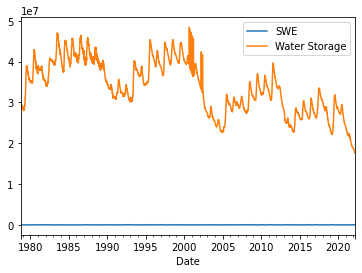

In [17]:
masterdata.plot()

Without interpolating SWE over the areas between stations where snow accumulates, the values of SWE don't match or compare with the changes in water storage. Thus we may look at water storage and water withdrawals directly.

In [18]:
# Bringing in water withdrawal data

aquaculture_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_Aquaculture.csv')
commercial_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_Commercial.csv')
hydropower_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_Hydro_Power.csv')
irrigation_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_Irrigation.csv')
livestock_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_Livestock.csv')
mining_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_Mining.csv')
public_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_PublicSupply.csv')
ss_domestic_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_SS_Domestic.csv')
ss_industrial_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_SS_Industrial.csv')
thermoelectric_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_Total_Thermoelectric.csv')
wastewater_withdrawals = pd.read_csv(f'../00_Source_Data/Snowpack/Water Usage/CRB_HUC8_TAF_19852010_Wastewater.csv')

C:\Users\bjere\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
# Define a function to remove XLS file artifacts from dataframes.

def del_unnamed(df):
    cols = df.columns.tolist()
    to_remove = []
    
    for i in cols:
        if i.startswith('Unnamed'):
            to_remove.append(i)
    return df.drop(columns=to_remove)

In [20]:
# Remove all artifact columns from all withdrawal datasets

aquaculture_withdrawals = del_unnamed(aquaculture_withdrawals)
commercial_withdrawals = del_unnamed(commercial_withdrawals)
hydropower_withdrawals = del_unnamed(hydropower_withdrawals)
irrigation_withdrawals = del_unnamed(irrigation_withdrawals)
livestock_withdrawals = del_unnamed(livestock_withdrawals)
mining_withdrawals = del_unnamed(mining_withdrawals)
public_withdrawals = del_unnamed(public_withdrawals)
ss_domestic_withdrawals = del_unnamed(ss_domestic_withdrawals)
ss_industrial_withdrawals = del_unnamed(ss_industrial_withdrawals)
thermoelectric_withdrawals = del_unnamed(thermoelectric_withdrawals)
wastewater_withdrawals = del_unnamed(wastewater_withdrawals)

 Each dataset has differing columns but the premise of how to put it all together is relatively simple. The total amount of consumed water is subtracted from total water storage. Water reclaimed is added to water storage. Each time period is treated as independant from the previous as the resulting storage is actual and thus should already include the values in the withdrawals data sets.
 
 Most dams have a minimum water level they maintain, so we will reduce the total storage per time figure by an amount equal to a percentage of the maximum (estimated by maximum in our dataset) to account for minimum operating depths in reservoirs and hydroelectric dams.

In [21]:
# doing some quick math because facts are in different scales.
# Depth is in feet.

total_water_depth = 710
min_operating = 3490
dead_pool = 3370
lake_elevation = 3700

per_to_dead = (lake_elevation - dead_pool)/total_water_depth
per_to_non_op = (lake_elevation - min_operating)/total_water_depth

print(f'Glen Canyon Dam has a minimum operating depth of {round(per_to_non_op*100)}% of the full depth.')
print(f'Glen Canyon Dam has a minimum flow-through depth of {round(per_to_dead*100)}% of the full depth. Also called the "dead pool" depth.')

Glen Canyon Dam has a minimum operating depth of 30% of the full depth.
Glen Canyon Dam has a minimum flow-through depth of 46% of the full depth. Also called the "dead pool" depth.


We will use Glen Canyon as our model dam, as it is difficult to find information on the dead pool and minimum operating depths of most other dams and reservoirs on the Colorado.

Thus, we can generalize that all water storage cannot drop below 46% percent of the maximum idealy. Dropping below 30% of the maximum storage is dire.

#### Formatting procedures

- Index to year as datetime.
- groupby date and aggregate total consumptive water withdrawal and total water reclaimed

Columns of interest by dataframe (units in TAF unless stated otherwise):

- Aquaculture: `'AQ-WTotl'` total fresh and saline withdrawals
- Commercial: `'CO-WFrTotl'` total water usage fresh
- Hydro power: `'HY-ToUse'` total instream and offstream water withdrawals defined by producer
        - Not differentiated between consumed and reclaimed.
        - Assuming all hydro power 'withdrawals' are flowthrough and not consumptive
- Irrigation: `'IR-WFrTo'` total fresh water withdrawls
        - Not differentiated between consumptive, conveyance losses, and evap.
- Livestock: `'LS-WTotl'` total fresh water withdrawals
        - Saline withdrawals not included.
- Mining: `'MI-WTotl'` total fresh and saline withdrawals
- Public: `'PS-WTotl'` total fresh and saline withdrawals
        - Public water totals appear to be delivered and included in other categories.
- SS Domestic: `'DO-WTotl'` total self-supplied withdrawals
- SS Industrial: `'IN-WTotl'` total self-supplied fresh and saline withdrawals
- Thermoelectric: `'PT-CUTot'` total fresh and saline consumptive use
- Wastewater: `'WW-PuRet'` total return flow

In [22]:
def format_water_data(df, column):
    df.index = pd.to_datetime(df['YEAR'], format='%Y', infer_datetime_format=True)
    return df.groupby(df.index).aggregate({column : 'sum'})
        

In [23]:
# format water withdrawal data 
aq_totls = format_water_data(aquaculture_withdrawals, 'AQ-WTotl')
com_totls = format_water_data(commercial_withdrawals, 'CO-WFrTotl')
hydro_totls = format_water_data(hydropower_withdrawals, 'HY-ToUse')
irr_totls = format_water_data(irrigation_withdrawals, 'IR-WFrTo')
ls_totls = format_water_data(livestock_withdrawals, 'LS-WTotl')
mi_totls = format_water_data(mining_withdrawals, 'MI-WTotl')
pub_totls = format_water_data(public_withdrawals, 'PS-WTotl')
ss_dom_totls = format_water_data(ss_domestic_withdrawals, 'DO-WTotl')
ss_ind_totls = format_water_data(ss_industrial_withdrawals, 'IN-WTotl')
te_totls = format_water_data(thermoelectric_withdrawals, 'PT-CUTot')
ww_totls = format_water_data(wastewater_withdrawals, 'WW-PuRet')

In [24]:
water_withdrawals = aq_totls.join([com_totls, hydro_totls, irr_totls, ls_totls, mi_totls,
                                   pub_totls, ss_dom_totls, ss_ind_totls, te_totls, ww_totls])

In [25]:
water_withdrawals

,AQ-WTotl,CO-WFrTotl,HY-ToUse,IR-WFrTo,LS-WTotl,MI-WTotl,PS-WTotl,DO-WTotl,IN-WTotl,PT-CUTot,WW-PuRet
YEAR,,,,,,,,,,,
2000-01-01,154.62,22.29,52485.04,14975.81,45.54,231.62,1910.20,66.68,33.00,235.90,1786.04
2005-01-01,142.15,26.94,43617.69,14818.85,41.35,183.30,1988.93,75.60,31.35,332.57,1699.78
2010-01-01,151.35,30.49,46076.89,13648.80,43.77,176.37,2096.00,69.44,31.67,328.20,1753.24


In [26]:
# turn withdrawals into negative numbers and returns into positive numbers.

if water_withdrawals['AQ-WTotl'][0] > 0:
    for i in water_withdrawals.columns:
        water_withdrawals[i] = water_withdrawals[i]*-1

if water_withdrawals['WW-PuRet'][0] < 0:
    water_withdrawals['WW-PuRet'] = water_withdrawals['WW-PuRet']*-1

In [27]:
water_withdrawals

,AQ-WTotl,CO-WFrTotl,HY-ToUse,IR-WFrTo,LS-WTotl,MI-WTotl,PS-WTotl,DO-WTotl,IN-WTotl,PT-CUTot,WW-PuRet
YEAR,,,,,,,,,,,
2000-01-01,-154.62,-22.29,-52485.04,-14975.81,-45.54,-231.62,-1910.20,-66.68,-33.00,-235.90,1786.04
2005-01-01,-142.15,-26.94,-43617.69,-14818.85,-41.35,-183.30,-1988.93,-75.60,-31.35,-332.57,1699.78
2010-01-01,-151.35,-30.49,-46076.89,-13648.80,-43.77,-176.37,-2096.00,-69.44,-31.67,-328.20,1753.24


In [28]:
water_withdrawals['Total Withdrawals'] = water_withdrawals['AQ-WTotl'] + \
                                         water_withdrawals['CO-WFrTotl'] + \
                                         water_withdrawals['IR-WFrTo'] + \
                                         water_withdrawals['LS-WTotl'] + \
                                         water_withdrawals['MI-WTotl'] + \
                                         water_withdrawals['DO-WTotl'] + \
                                         water_withdrawals['IN-WTotl'] + \
                                         water_withdrawals['PT-CUTot'] + \
                                         water_withdrawals['WW-PuRet']

In [29]:
water_withdrawals

,AQ-WTotl,CO-WFrTotl,HY-ToUse,IR-WFrTo,LS-WTotl,MI-WTotl,PS-WTotl,DO-WTotl,IN-WTotl,PT-CUTot,WW-PuRet,Total Withdrawals
YEAR,,,,,,,,,,,,
2000-01-01,-154.62,-22.29,-52485.04,-14975.81,-45.54,-231.62,-1910.20,-66.68,-33.00,-235.90,1786.04,-13979.42
2005-01-01,-142.15,-26.94,-43617.69,-14818.85,-41.35,-183.30,-1988.93,-75.60,-31.35,-332.57,1699.78,-13952.33
2010-01-01,-151.35,-30.49,-46076.89,-13648.80,-43.77,-176.37,-2096.00,-69.44,-31.67,-328.20,1753.24,-12726.85


#### Addressing differences in units

The master dataset has water in dam^3 and our water withdrawals are in TAFs.

So, we will convert our withdrawals to dam^3.

$\dfrac {1233.48 \text{dam}^3}{1000 \text{acre-feet}}$

so simply multiply the rows by 1233.48

In [30]:
for i in water_withdrawals.columns:
        water_withdrawals[i] = water_withdrawals[i]*1233.48

Now all measurements of water are in cubic decameters ($\text{dam}^3$)

### Resampling and visualizing

In [31]:
graphing = masterdata.join(water_withdrawals.drop(columns=['HY-ToUse', 'PS-WTotl'])).resample('1D').median()

In [32]:
graphing = graphing.fillna(value=None, method='backfill', axis=None, limit=None, downcast=None)
graphing = graphing.fillna(value=None, method='ffill', axis=None, limit=None, downcast=None)

In [33]:
graphing

,SWE,Water Storage,AQ-WTotl,CO-WFrTotl,IR-WFrTo,LS-WTotl,MI-WTotl,DO-WTotl,IN-WTotl,PT-CUTot,WW-PuRet,Total Withdrawals
Date,,,,,,,,,,,,
1978-09-30,0.0,29913012.0,-190720.6776,-27494.2692,-1.847236e+07,-56172.6792,-285698.6376,-82248.4464,-40704.8400,-290977.932,2.203045e+06,-1.724333e+07
1978-10-01,2354.0,29894823.0,-190720.6776,-27494.2692,-1.847236e+07,-56172.6792,-285698.6376,-82248.4464,-40704.8400,-290977.932,2.203045e+06,-1.724333e+07
1978-10-02,0.0,29800335.0,-190720.6776,-27494.2692,-1.847236e+07,-56172.6792,-285698.6376,-82248.4464,-40704.8400,-290977.932,2.203045e+06,-1.724333e+07
1978-10-03,0.0,29826110.0,-190720.6776,-27494.2692,-1.847236e+07,-56172.6792,-285698.6376,-82248.4464,-40704.8400,-290977.932,2.203045e+06,-1.724333e+07
1978-10-04,0.0,29754881.0,-190720.6776,-27494.2692,-1.847236e+07,-56172.6792,-285698.6376,-82248.4464,-40704.8400,-290977.932,2.203045e+06,-1.724333e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,45372.0,17685824.0,-186687.1980,-37608.8052,-1.683552e+07,-53989.4196,-217548.8676,-85652.8512,-39064.3116,-404828.136,2.162586e+06,-1.569831e+07
2022-04-01,45536.0,17639916.0,-186687.1980,-37608.8052,-1.683552e+07,-53989.4196,-217548.8676,-85652.8512,-39064.3116,-404828.136,2.162586e+06,-1.569831e+07
2022-04-02,44888.0,17641640.0,-186687.1980,-37608.8052,-1.683552e+07,-53989.4196,-217548.8676,-85652.8512,-39064.3116,-404828.136,2.162586e+06,-1.569831e+07


In [34]:
graphing['Remaining Water'] = graphing['Water Storage'] + graphing['Total Withdrawals']

In [35]:
graphing['Remaining Water']

Date
1978-09-30    1.266968e+07
1978-10-01    1.265149e+07
1978-10-02    1.255700e+07
1978-10-03    1.258278e+07
1978-10-04    1.251155e+07
                  ...     
2022-03-31    1.987509e+06
2022-04-01    1.941601e+06
2022-04-02    1.943325e+06
2022-04-03    1.943325e+06
2022-04-04    1.943325e+06
Freq: D, Name: Remaining Water, Length: 15893, dtype: float64

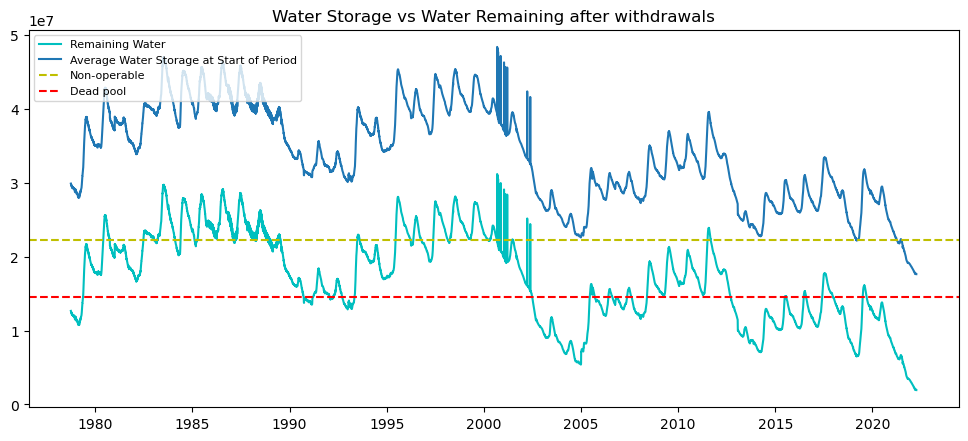

In [36]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(graphing['Remaining Water'], label='Remaining Water', color = 'c' )
plt.plot(graphing['Water Storage'], label='Average Water Storage at Start of Period')
#plt.plot(graphing['Total Withdrawals'], label='Withdrawals', color='r')
plt.axhline(graphing['Water Storage'].max()*0.46, color='y', linestyle='--', label= 'Non-operable')
plt.axhline(graphing['Water Storage'].max()*0.30, color='r', linestyle='--', label= 'Dead pool')
plt.title('Water Storage vs Water Remaining after withdrawals')
plt.legend(loc='upper left', fontsize=8)
plt.show();

### Creating a target columns

Definitions for Trinary targets
 - 0 = Dead pool
 - 1 = Non-op for hydroelectric dams
 - 2 = Enough water for operation
 
Definitions for Binary targets
 - 0 = Dead pool
 - 1 = Enough water for operation

In [37]:
nonop = graphing['Water Storage'].max()*0.46
dead = graphing['Water Storage'].max()*0.30

graphing['target_binary'] = np.where(graphing['Remaining Water'] > dead, 1, 0)

graphing['target_trinary'] = np.where(graphing['Remaining Water'] > nonop, 2, 
                                      np.where(graphing['Remaining Water'] > dead, 1, 0))

In [38]:
graphing.target_trinary.value_counts()

1    6196
0    5732
2    3965
Name: target_trinary, dtype: int64

# Modeling

#### Metrics of interest

We are interested in precision because we are discussing water resources

## Train-test split

Performing train test split by time.

Train will contain 80% of the oldest data.

Test will contain 20% of the newest data.

This ratio may change for future models if stuff gets weird.

In [39]:
# importing relevant libraries
from sklearn.model_selection import train_test_split

In [40]:
# We will use 20% of the most recent data as a test set
cutoff = round(graphing.shape[0]*0.8)

# splitting train and test
time_train = graphing[:cutoff]
time_test = graphing[cutoff:]

# Second train-test split for logistic regression
# splitting into dataframes with predictors and dataframes with targets
#X = graphing.drop(columns=['Remaining Water', 'target_binary', 'target_trinary', 'Total Withdrawals'])
X = graphing[['Water Storage', 'SWE']]

y = graphing[['target_binary', 'target_trinary']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [41]:
# scoring function
def score(model, target, predictor):
    mod_type = str(model).split('(')[0]
    print(f'Our {mod_type} model has a precision of: \
      {round(precision_score(target, model.predict(predictor), average = "weighted", zero_division=0),3)*100}%')

## Dummy Model

In [42]:
# Importing dummy model library
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#### Binary target

In [43]:
# instantiate the dummy model
b_model_0 = DummyClassifier(random_state=42, strategy='most_frequent')

# Fit the model to the training set
b_model_0.fit(X_train, y_train['target_binary'])

DummyClassifier(random_state=42, strategy='most_frequent')

In [44]:
score(b_model_0, y_test['target_binary'], X_test)

Our DummyClassifier model has a precision of:       41.4%


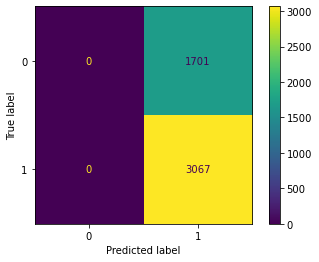

In [45]:
ConfusionMatrixDisplay(confusion_matrix(y_test['target_binary'],b_model_0.predict(X_test))).plot()

#### Trinary target

In [46]:
# instantiate the dummy model
t_model_0 = DummyClassifier(random_state=42, strategy='most_frequent')

# Fit the model to the training set
t_model_0.fit(X_train, y_train['target_trinary'])

DummyClassifier(random_state=42, strategy='most_frequent')

In [47]:
score(t_model_0, y_test['target_trinary'], X_test)

Our DummyClassifier model has a precision of:       15.6%


## First Simple Model (FSM)

We will do a simple logistic regression to model the status of water in the Colorado Basin

In [48]:
# importing relevant libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#### Scaling predictors

In [49]:
ss = StandardScaler()

X_tr_scaled = ss.fit_transform(X_train)
X_te_scaled = ss.transform(X_test)

#### Binary Target

In [50]:
# instantiate the logistic model
b_model_1 = LogisticRegression(random_state=42, solver='newton-cg')

# Fit the model to the training set
b_model_1.fit(X_tr_scaled, y_train['target_binary'])

LogisticRegression(random_state=42, solver='newton-cg')

In [51]:
# Score the model
score(b_model_1, y_test['target_binary'], X_te_scaled)

Our LogisticRegression model has a precision of:       95.8%


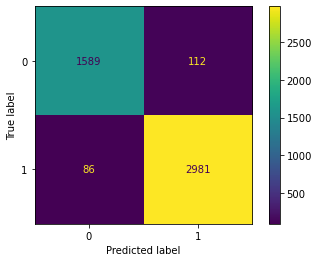

In [52]:
ConfusionMatrixDisplay(confusion_matrix(y_test['target_binary'],b_model_1.predict(X_te_scaled))).plot()

#### Trinary Target

In [53]:
# instantiate the logistic model
t_model_1 = LogisticRegression(multi_class='multinomial',
                               solver='newton-cg')

# Fit the model to the training set
t_model_1.fit(X_tr_scaled, y_train['target_trinary'])

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [54]:
# Score the model
print('Train Score:')
score(t_model_1, y_train['target_trinary'], X_tr_scaled)
print('Test Score:')
score(t_model_1, y_test['target_trinary'], X_te_scaled)

Train Score:
Our LogisticRegression model has a precision of:       94.39999999999999%
Test Score:
Our LogisticRegression model has a precision of:       94.69999999999999%


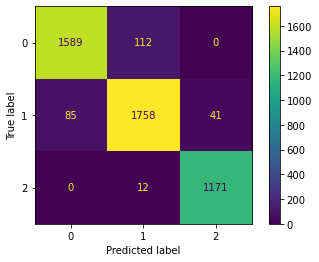

In [55]:
ConfusionMatrixDisplay(confusion_matrix(y_test['target_trinary'],t_model_1.predict(X_te_scaled))).plot()

While this model seems to do an excellent job with precision, we worry that this model's accuracy may be a result of colinearity. We will perform a grid search with several L1 and L2 penalty values to evaluate what may be best.

## Model 2

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [57]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']},
    {'classifier' : [KNeighborsClassifier()],
     'classifier__n_neighbors' : list(range(10,20,1)),
     'classifier__n_jobs': [-1]},
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : list(range(1,101,20)),
     'classifier__max_depth' : list(range(1, 31, 5))}
]


# Create a gridsearch object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1, error_score='raise')


# First attempt on untransformed data

best_clf = clf.fit(X_train, y_train['target_trinary'])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


KeyboardInterrupt: 

In [ ]:
best_clf.best_params_

In [ ]:
best_clf.best_score_

In [ ]:
best_clf.scorer_

Given that the scale of our data is largely different, we should standardize the scale of our data for the purpose of this model.

In [ ]:
# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']},
    {'classifier' : [KNeighborsClassifier()],
     'classifier__n_neighbors' : list(range(10,20,1)),
     'classifier__n_jobs': [-1]},
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : list(range(1,101,20)),
     'classifier__max_depth' : list(range(1, 31, 5))}
]


# Create a gridsearch object

scaled_clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1, error_score='raise')


# Second attempt on scaled data

best_scaled_clf = scaled_clf.fit(X_tr_scaled, y_train['target_trinary'])

print(f'Best parameters: {best_scaled_clf.best_params_}')

So, our Random Forest did better than both a logistic regression and a KNN model, with a resulting score of 98.4% with the parameters listed above. Our final model will look like the below such that we are not running tuning algorithms each time.

In [ ]:
# run the pipeline scaled without the optimized parameters
pipe.fit(X_tr_scaled, y_train['target_trinary'])

print('Training set score: ' + str(pipe.score(X_tr_scaled,y_train['target_trinary'])))
print('Test set score: ' + str(pipe.score(X_te_scaled,y_test['target_trinary'])))

In [ ]:
# run the pipeline scaled and with the optimized parameters

pipe = Pipeline([('classifier' , RandomForestClassifier(max_depth=11, n_estimators=61))])

pipe.fit(X_tr_scaled, y_train['target_trinary'])

print('Training set score: ' + str(pipe.score(X_tr_scaled,y_train['target_trinary'])))
print('Test set score: ' + str(pipe.score(X_te_scaled,y_test['target_trinary'])))

## Model 3: Adding time series elements

Here we will try a Time Series Forest model from the PyTS library. Our previous models were not time series models and thus excluded the presence of time and the relationship in the data that comes with time. This next model should relate better to the data because the original data is a time series and thus relationships between the data and time not overlooked by the simplicity of the model.

This model was developed specifically for doing classification with time series data. Citation below.

Johann Faouzi and Hicham Janati. pyts: A python package for time series classification.<br>
Journal of Machine Learning Research, 21(46):1−6, 2020.

In [ ]:
v# Install PyTS
!pip install pyts

In [ ]:
# Import the model
from pyts.classification import TimeSeriesForest

In [ ]:
# create a pipeline object for the classification model

time_pipe = Pipeline([('classifier', TimeSeriesForest())])

# Create a param grid for tuning

param_grid = [
              {'classifier' : [TimeSeriesForest()],
               'classifier__n_estimators' : list(range(100, 500, 100)),
               'classifier__n_windows' : [0.1, 0.5, 1],
               'classifier__max_depth' : [None] + list(range(10, 100, 15)),}
]

In [ ]:
# First attempt without tuning or scaling

time_pipe.fit(X_train, y_train['target_trinary'])

print('Training set score: ' + str(time_pipe.score(X_train,y_train['target_trinary'])))
print('Test set score: ' + str(time_pipe.score(X_test,y_test['target_trinary'])))

In [ ]:
# First attempt without tuning but scaled

time_pipe.fit(X_tr_scaled, y_train['target_trinary'])

print('Training set score: ' + str(time_pipe.score(X_tr_scaled,y_train['target_trinary'])))
print('Test set score: ' + str(time_pipe.score(X_te_scaled,y_test['target_trinary'])))

Without any parameters, the timeseriesforest overfits, but still has good score of 95% accuracy and appears to be somewhat overfit. With the scaled data, accuracy rises to 97% but is also overfit.

Lets perform a grid search to optomize some of these parameters.

In [ ]:
# Create new gridsearch object

scaled_tsf = GridSearchCV(time_pipe, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1, error_score='raise')

# run gridsearch on scaled train data

best_scaled_tsf = scaled_tsf.fit(X_tr_scaled, y_train['target_trinary'])

print(f'Best parameters: {best_scaled_tsf.best_params_}')

Our final optimized model and an unoptimized comparison are below.

In [ ]:
# run the pipeline scaled without the optimized parameters
time_pipe.fit(X_tr_scaled, y_train['target_trinary'])

print('Training set score: ' + str(time_pipe.score(X_tr_scaled,y_train['target_trinary'])))
print('Test set score: ' + str(time_pipe.score(X_te_scaled,y_test['target_trinary'])))

In [ ]:
# run the pipeline scaled and with the optimized parameters

time_pipe_opt = Pipeline([('classifier', TimeSeriesForest(max_depth=10, n_estimators=700, n_windows=0.1))])

time_pipe_opt.fit(X_tr_scaled, y_train['target_trinary'])

print('Training set score: ' + str(time_pipe_opt.score(X_tr_scaled,y_train['target_trinary'])))
print('Test set score: ' + str(time_pipe_opt.score(X_te_scaled,y_test['target_trinary'])))

For the sake of curiousity, lets see what the difference is in the model if we use a MinMax scaler (less susceptible to outliers).

In [ ]:
# Import minmax scaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# create pipeline for MinMax scaler and TimeSeriesForest
time_pipe_minmax = Pipeline([('scaler', MinMaxScaler()), ('classifier', TimeSeriesForest(max_depth=10, n_estimators=700, n_windows=0.1))])

time_pipe_minmax.fit(X_train, y_train['target_trinary'])

print('Training set score: ' + str(time_pipe_minmax.score(X_train, y_train['target_trinary'])))
print('Test set score: ' + str(time_pipe_minmax.score(X_test, y_test['target_trinary'])))

While the accuracy of the model dropped a minute amount, we feel that reducing the sensitivity of the model to outliers provides more sound results.

# Finalizing Visualizations

### Water Storage Visuals

<IPython.core.display.Math object>

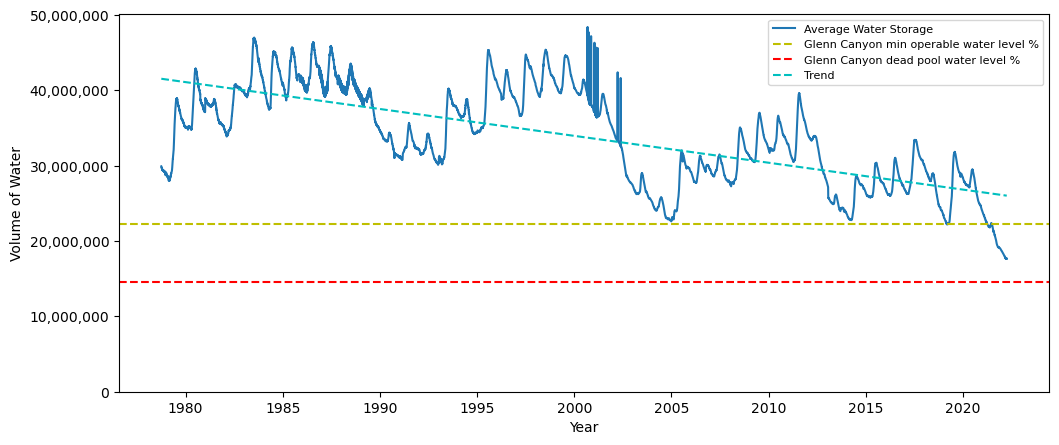

In [58]:
#import dates module
import matplotlib.dates as mdates
from IPython.display import display, Math
import matplotlib.ticker as ticker


# Set trendline values
x = mdates.date2num(graphing.index)
y = graphing['Water Storage']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Plot time series of water storage
plt.figure(figsize=(12,5), dpi=100)
plt.plot(graphing['Water Storage'], label='Average Water Storage')
plt.axhline(graphing['Water Storage'].max()*0.46, color='y', linestyle='--', label= 'Glenn Canyon min operable water level %')
plt.axhline(graphing['Water Storage'].max()*0.30, color='r', linestyle='--', label= 'Glenn Canyon dead pool water level %')
plt.title(display(Math(r'\text{Volume of Water Stored in CRB Dams }(dam^3)')))
plt.xlabel('Year')
plt.ylabel('Volume of Water')
plt.plot(x, p(x), "c--", label='Trend')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(ymin=0)
plt.legend(loc='upper right', fontsize=8)
plt.savefig(f'../images/water_storage_ts.png', bbox_inches='tight', transparent=True)
plt.show();

### Water Usage Visuals

In [59]:
# Recompile water usage data
# List of interested columns
useage = ['AQ-WTotl','CO-WFrTotl', 'IR-WFrTo', 'LS-WTotl', 'DO-WTotl', 'IN-WTotl', 'PT-CUTot']
names = ['Aquaculture', 'Commercial', 'Irrigation', 'Livestock', 'Domestic', 'Industrial', 'Thermoelectric']

water_usage = water_withdrawals[useage] * -1
water_usage = water_usage.transpose()

#creating dict for renaming of columns
columns = water_usage.columns.to_list()
items = [2000, 2005, 2010]

col_dict = dict(zip(useage, names))

water_usage = water_usage.rename(col_dict)

water_usage

YEAR,2000-01-01,2005-01-01,2010-01-01
Aquaculture,1.907207e+05,1.753392e+05,1.866872e+05
Commercial,2.749427e+04,3.322995e+04,3.760881e+04
Irrigation,1.847236e+07,1.827876e+07,1.683552e+07
Livestock,5.617268e+04,5.100440e+04,5.398942e+04
Domestic,8.224845e+04,9.325109e+04,8.565285e+04
Industrial,4.070484e+04,3.866960e+04,3.906431e+04
Thermoelectric,2.909779e+05,4.102184e+05,4.048281e+05


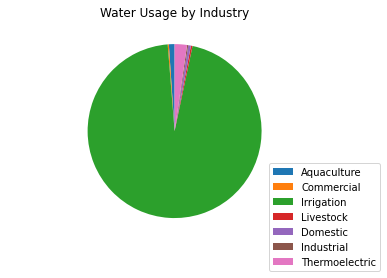

In [60]:
# Pie chart to show overwhelming wateruse by irrigation
labels=water_usage.index.to_list()

plt.gca().axis("equal")
pie = plt.pie(water_usage['2010-01-01'], startangle=90)
plt.legend(pie[0],labels, bbox_to_anchor=(1,0), loc="lower right", 
                          bbox_transform=plt.gcf().transFigure)
plt.title('Water Usage by Industry')
plt.savefig(f'../images/water_usage_pie.png', bbox_inches='tight', transparent=True)
plt.show();

In [61]:
# Breakdown of Irrigation

junk = ['STATECODE', 'HUC4CODE', 'HUC8CODE', 'HUCNAME']
ir_types = ['IR-IrSpr', 'IR-IrMic', 'IR-IrSur']
ir_withdrawals = ['IR-WGWFr', 'IR-WSWFr']

ir_breakdown = irrigation_withdrawals.dropna().drop(columns=junk).reset_index(drop=True)

In [62]:
# set up labels
types_labels = ['Sprinkler Irrigation', 'Micro-irrigation', 'Surface Irrigation']
withdr_labels = ['Fresh Ground Water', 'Fresh Surface Water']

ir_bd_sum = ir_breakdown.groupby('YEAR').sum()

ir_bd_sum.rename(columns=dict(zip(ir_types,types_labels)), inplace=True)
ir_bd_sum.rename(columns=dict(zip(ir_withdrawals,withdr_labels)), inplace=True)
ir_bd_sum.drop(columns= ['IR-WFrTo', 'IR-CUsFr', 'IR-CLoss', 'IR-IrTot'], inplace=True)
ir_bd_sum

,Fresh Ground Water,Fresh Surface Water,Sprinkler Irrigation,Micro-irrigation,Surface Irrigation
YEAR,,,,,
1985.0,2943.53,12089.84,334.38,0.00,2301.41
1990.0,2550.87,11636.03,466.36,0.00,2308.40
1995.0,2462.45,12088.18,450.37,16.46,2424.34
2000.0,2923.23,12052.45,519.17,14.33,2155.55
2005.0,2828.28,11990.79,596.72,21.49,2021.70
2010.0,2058.26,11576.59,553.88,33.22,2141.88


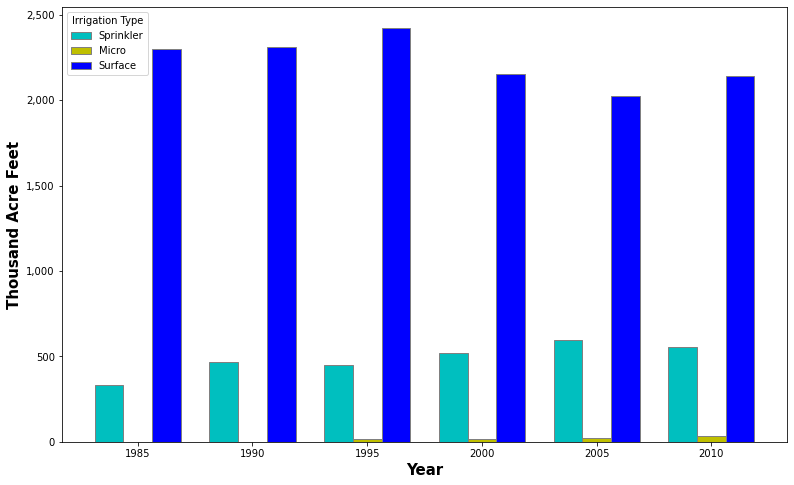

In [63]:
# Plot irrigation types

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(13, 8))
 
# set height of bar
spr = ir_bd_sum['Sprinkler Irrigation'].to_list()
mic = ir_bd_sum['Micro-irrigation'].to_list()
sur = ir_bd_sum['Surface Irrigation'].to_list()
 
# Set position of bar on X axis
br1 = np.arange(len(spr))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, spr, color ='c', width = barWidth,
        edgecolor ='grey', label ='Sprinkler')
plt.bar(br2, mic, color ='y', width = barWidth,
        edgecolor ='grey', label ='Micro')
plt.bar(br3, sur, color ='b', width = barWidth,
        edgecolor ='grey', label ='Surface')
 
# Adding Xticks
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Year', fontweight ='bold', fontsize = 15)
plt.ylabel('Thousand Acre Feet', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(spr))],
        [int(x) for x in ir_bd_sum.index.to_list()])
 
plt.legend(title="Irrigation Type", loc='upper left')
plt.savefig(f'../images/water_usage_bar.png', bbox_inches='tight', transparent=True)
plt.show();